In [1]:
import numpy as np
import pandas as pd
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import random
from collections import Counter
from sklearn.metrics import roc_curve, auc, average_precision_score
import joblib

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# 导入数据集并列表显示
path = './steam-video-games/steam-200k.csv'
df = pd.read_csv(path, header = None, names = ['UserID', 'Game', 'Action', 'Hours', 'Not Needed'])
df.head()

,UserID,Game,Action,Hours,Not Needed
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
1,151603712,The Elder Scrolls V Skyrim,play,273.0,0
2,151603712,Fallout 4,purchase,1.0,0
3,151603712,Fallout 4,play,87.0,0
4,151603712,Spore,purchase,1.0,0


In [3]:
# 从购买记录和游玩记录中筛选出游戏时长
df['Hours_Played'] = df['Hours'].astype('float32')
df.loc[(df['Action'] == 'purchase') & (df['Hours'] == 1.0), 'Hours_Played'] = 0

# 排序
df.UserID = df.UserID.astype('int')
df = df.sort_values(['UserID', 'Game', 'Hours_Played'])

# 整理为新的表格clean_df
clean_df = df.drop_duplicates(['UserID', 'Game'], keep = 'last').drop(['Action', 'Hours', 'Not Needed'], axis = 1)
clean_df.head()

,UserID,Game,Hours_Played
65430,5250,Alien Swarm,4.9
65424,5250,Cities Skylines,144.0
65435,5250,Counter-Strike,0.0
65436,5250,Counter-Strike Source,0.0
65437,5250,Day of Defeat,0.0


In [4]:
n_users = len(clean_df.UserID.unique())
n_games = len(clean_df.Game.unique())
print('用户-游戏数据集中一共有{0}个用户，{1}个游戏'.format(n_users, n_games))

用户-游戏数据集中一共有12393个用户，5155个游戏


In [5]:
# 计算矩阵的稀疏程度
sparsity = clean_df.shape[0] / float(n_users * n_games)
print('用户-游戏矩阵中有效数据占比为：{:.2%}'.format(sparsity))

用户-游戏矩阵中有效数据占比为：0.20%


In [6]:
# 建立序列化的id方便使用

# 用户id到用户序列化id的字典
user2idx = {user: i for i, user in enumerate(clean_df.UserID.unique())}
# 用户序列化id到用户id的字典
idx2user = {i: user for user, i in user2idx.items()}

# 游戏名到游戏序列化id的字典
game2idx = {game: i for i, game in enumerate(clean_df.Game.unique())}
# 游戏序列化id到游戏名的字典
idx2game = {i: game for game, i in game2idx.items()}

# 将字典保存，用于PyQt5中
joblib.dump(idx2game, './Save_data/idx2game.pkl')
joblib.dump(game2idx, './Save_data/game2idx.pkl')

['./Save_data/game2idx.pkl']

In [7]:
# 用户序列化id-游戏序列化id-游戏时长
user_idx = clean_df['UserID'].apply(lambda x: user2idx[x]).values
game_idx = clean_df['gamesIdx'] = clean_df['Game'].apply(lambda x:game2idx[x]).values
hours = clean_df['Hours_Played'].values
# 保存游戏时长矩阵
hours_save = np.zeros(shape = (n_users, n_games))
for i in range(len(user_idx)):
    hours_save[user_idx[i], game_idx[i]] = hours[i]
joblib.dump(hours_save, './Save_data/hours.pkl')

['./Save_data/hours.pkl']

## 建立用户-游戏评分矩阵

In [8]:
# 建立稀疏矩阵存储大数据集
# 
# 购买矩阵:
# 未购买标识为0
# 购买标识为1
# 
# 置信度矩阵：
# 根据游戏时长提高置信度，最低为1

zero_matrix = np.zeros(shape = (n_users, n_games))
# 购买矩阵
user_game_pref = zero_matrix.copy()
user_game_pref[user_idx, game_idx] = 1
# 保存购买矩阵
joblib.dump(user_game_pref, './Save_data/buy.pkl')
# 置信度矩阵
user_game_interactions = zero_matrix.copy()
user_game_interactions[user_idx, game_idx] = hours + 1

## 验证

In [9]:
k = 5

# 对于每个用户计算他们购买的游戏数量
purchase_counts = np.apply_along_axis(np.bincount, 1, user_game_pref.astype(int))
buyers_idx = np.where(purchase_counts[:, 1] >= 2 * k)[0] #购买超过2*k个游戏的买家集合
print('{0}名玩家购买了至少{1}款游戏'.format(len(buyers_idx), 2 * k))
# 保存有效购买用户名单
joblib.dump(buyers_idx, './Save_data/buyers.pkl')

2189名玩家购买了至少10款游戏


['./Save_data/buyers.pkl']

In [10]:
test_frac = 0.2 # 10%数据用来验证，10%数据用来测试
test_users_idx = np.random.choice(buyers_idx, 
                                  size = int(np.ceil(len(buyers_idx) * test_frac)), 
                                  replace = False)
val_users_idx = test_users_idx[:int(len(test_users_idx) / 2)]
test_users_idx = test_users_idx[int(len(test_users_idx) / 2):]

In [11]:
# 在训练集中掩盖k个游戏
def data_process(dat, train, test, user_idx, k):
    for user in user_idx:
        purchases = np.where(dat[user, :] == 1)[0]
        mask = np.random.choice(purchases, size = k, replace = False)
        train[user, mask] = 0
        test[user, mask] = dat[user, mask]
    return train, test

In [12]:
train_matrix = user_game_pref.copy()
test_matrix = zero_matrix.copy()
val_matrix = zero_matrix.copy()

train_matrix, val_matrix = data_process(user_game_pref, train_matrix, val_matrix, val_users_idx, k)
train_matrix, test_matrix = data_process(user_game_pref, train_matrix, test_matrix, test_users_idx, k)

In [13]:
test_matrix[test_users_idx[0], test_matrix[test_users_idx[0], :].nonzero()[0]]

array([1., 1., 1., 1., 1.])

In [14]:
train_matrix[test_users_idx[0], test_matrix[test_users_idx[0], :].nonzero()[0]]

array([0., 0., 0., 0., 0.])

In [15]:
tf.reset_default_graph()

# 偏好矩阵
pref = tf.placeholder(tf.float32, (n_users, n_games))
# 游戏时间矩阵
interactions = tf.placeholder(tf.float32, (n_users, n_games))
user_idx = tf.placeholder(tf.int32, (None))

In [16]:
n_features = 30 # 隐藏特征个数设置为30

# X矩阵（用户-隐藏特征）表示用户潜在偏好
X = tf.Variable(tf.truncated_normal([n_users, n_features], mean = 0, stddev = 0.05), dtype = tf.float32, name = 'X')
# Y矩阵（游戏-隐藏特征）表示游戏潜在特征
Y = tf.Variable(tf.truncated_normal([n_games, n_features], mean = 0, stddev = 0.05), dtype = tf.float32, name = 'Y')

# 置信度参数初始化
conf_alpha = tf.Variable(tf.random_uniform([1], 0,1))

In [17]:
# 初始化用户偏差
user_bias = tf.Variable(tf.truncated_normal([n_users, 1], stddev = 0.2))

# 将向量连接到用户矩阵
X_plus_bias = tf.concat([X,
                        user_bias,
                        tf.ones((n_users, 1), dtype = tf.float32)], 
                        axis = 1)

In [18]:
# 初始化游戏偏差
item_bias = tf.Variable(tf.truncated_normal([n_games, 1], stddev = 0.2))

# 将向量连接到游戏矩阵
Y_plus_bias = tf.concat([Y,
                        tf.ones((n_games, 1), dtype = tf.float32),
                        item_bias],
                        axis = 1)

In [19]:
# 通过矩阵乘积确定结果评分矩阵
pred_pref = tf.matmul(X_plus_bias, Y_plus_bias, transpose_b = True)

# 使用游戏时长与alpha参数构造置信度矩阵
conf = 1 + conf_alpha * interactions

In [20]:
#损失函数
cost = tf.reduce_sum(tf.multiply(conf, tf.square(tf.subtract(pref, pred_pref))))
l2_sqr = tf.nn.l2_loss(X) + tf.nn.l2_loss(Y) + tf.nn.l2_loss(user_bias) + tf.nn.l2_loss(item_bias)
lambda_c = 0.01
loss = cost + lambda_c * l2_sqr

In [21]:
#梯度下降算法优化器
lr = 0.05
optimize = tf.train.AdagradOptimizer(learning_rate = lr).minimize(loss)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [22]:
# 精确度计算优化，将游戏本体和DLC合并为同一种游戏
def precision_dlc(recommandations, labels):
    # 推荐的游戏按单词划分
    recommandations_split = []
    # 实际购买的游戏按单词划分
    labels_split = []
    for label in labels:
        labels_split.append(idx2game[label].split())
    for game in recommandations:
        recommandations_split.append(idx2game[game].split())
        
    count = 0
    for game in recommandations_split:
        for label in labels_split:
            # 当推荐的游戏与实际购买的游戏单词重合度高于阈值判定为同一款游戏
            if (len(set(game) & set(label)) / min(len(game),len(label))) > 0.2:
                count += 1
                break
    
    return float(count / len(recommandations))
            

In [23]:
# 从预测的列表中挑选最高的k个
def top_k_precision(pred, mat, k, user_idx):
    precisions = []
    for user in user_idx:
        rec = np.argsort(-pred[user, :])
        # 选取推荐评分最高的k个
        top_k = rec[:k]
        labels = mat[user, :].nonzero()[0]
        # 计算推荐与实际的准确率并返回
        precision = precision_dlc(top_k, labels)
        precisions.append(precision)
    return np.mean(precisions)

In [24]:
iterations = 500
# 绘图用数据：误差、训练集准确率
fig_loss = np.zeros([iterations])
fig_train_precision = np.zeros([iterations])

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for i in range(iterations):
        sess.run(optimize, feed_dict = {pref: train_matrix, 
                                       interactions: user_game_interactions})
        if i % 10 == 0:
            mod_loss = sess.run(loss, feed_dict = {pref: train_matrix,
                                                   interactions: user_game_interactions})
            mod_pred = pred_pref.eval()
            train_precision = top_k_precision(mod_pred, train_matrix, k, val_users_idx)
            val_precision = top_k_precision(mod_pred, val_matrix, k, val_users_idx)
            print('当前进度：{}...'.format(i),
                  '误差为：{:.2f}...'.format(mod_loss),
                  '训练集上的正确率：{:.3f}...'.format(train_precision),
                  '验证集上的正确率：{:.3f}'.format(val_precision))
        fig_loss[i] = sess.run(loss, feed_dict = {pref: train_matrix,
                                                  interactions: user_game_interactions})
        fig_train_precision[i] = top_k_precision(mod_pred, train_matrix, k, val_users_idx)
    rec = pred_pref.eval()
    test_precision = top_k_precision(rec, test_matrix, k, test_users_idx)
    print('\n')
    print('模型完成，正确率为：{:.3f}'.format(test_precision))

2023-01-08 00:01:04.867516: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


当前进度：0... 误差为：3666590.75... 训练集上的正确率：0.465... 验证集上的正确率：0.247
当前进度：10... 误差为：273364.12... 训练集上的正确率：0.716... 验证集上的正确率：0.331
当前进度：20... 误差为：209843.83... 训练集上的正确率：0.747... 验证集上的正确率：0.358
当前进度：30... 误差为：181353.75... 训练集上的正确率：0.777... 验证集上的正确率：0.370
当前进度：40... 误差为：160562.83... 训练集上的正确率：0.804... 验证集上的正确率：0.373
当前进度：50... 误差为：142895.80... 训练集上的正确率：0.821... 验证集上的正确率：0.378
当前进度：60... 误差为：126207.24... 训练集上的正确率：0.826... 验证集上的正确率：0.379
当前进度：70... 误差为：108554.54... 训练集上的正确率：0.833... 验证集上的正确率：0.380
当前进度：80... 误差为：86285.98... 训练集上的正确率：0.836... 验证集上的正确率：0.386
当前进度：90... 误差为：33459.42... 训练集上的正确率：0.827... 验证集上的正确率：0.374
当前进度：100... 误差为：-1630931.88... 训练集上的正确率：0.732... 验证集上的正确率：0.347
当前进度：110... 误差为：-98294584.00... 训练集上的正确率：0.578... 验证集上的正确率：0.261
当前进度：120... 误差为：-822202816.00... 训练集上的正确率：0.535... 验证集上的正确率：0.229
当前进度：130... 误差为：-2845831936.00... 训练集上的正确率：0.494... 验证集上的正确率：0.209
当前进度：140... 误差为：-6727444480.00... 训练集上的正确率：0.468... 验证集上的正确率：0.195
当前进度：150... 误差为：-12936225792.00... 训练集上的正确率：0.457... 验证集上的正确率：0

In [25]:
n_examples = 5
users = np.random.choice(test_users_idx, size = n_examples, replace = False)
rec_games = np.argsort(-rec)

for user in users:
    purchase_history = np.where(train_matrix[user, : ] != 0)[0]
    recommandations = rec_games[user, : ]
    new_recommandations = recommandations[~np.in1d(recommandations, purchase_history)][:k]
    
    print('给id为{0}的玩家推荐的游戏如下：'.format(idx2user[user]))
    print('，'.join([idx2game[game] for game in new_recommandations]))
    print('玩家实际购买游戏如下：')
    print('，'.join([idx2game[game] for game in np.where(test_matrix[user, : ] != 0)[0]]))
    print('准确率：{:.2f}%'.format( 100 * precision_dlc(new_recommandations, np.where(test_matrix[user, : ] != 0)[0])))
    print('\n')

给id为248216340的玩家推荐的游戏如下：
Dota 2，Disciples III Reincarnation，GRID，Zombie Panic Source，Rocksmith 2014
玩家实际购买游戏如下：
Counter-Strike Global Offensive，Dead Island Epidemic，TERA，World of Guns Gun Disassembly，Gotham City Impostors Free To Play
准确率：0.00%


给id为5220782的玩家推荐的游戏如下：
Dota 2，Transformice，Rusty Hearts，Spiral Knights，Sword of the Stars II Enhanced Edition
玩家实际购买游戏如下：
Day of Defeat，Deathmatch Classic，Ricochet，Half-Life Deathmatch Source，Half-Life Source
准确率：20.00%


给id为148246305的玩家推荐的游戏如下：
Train Simulator，Rising Storm/Red Orchestra 2 Multiplayer，Sonic Generations，Counter-Strike Condition Zero，Farming Simulator 2013
玩家实际购买游戏如下：
theHunter，PAYDAY The Heist，Quake Live，World of Guns Gun Disassembly，AdVenture Capitalist
准确率：0.00%


给id为97614578的玩家推荐的游戏如下：
Disciples III Reincarnation，GRID，Zombie Panic Source，Out of the Park Baseball 16，Rocksmith 2014
玩家实际购买游戏如下：
War Thunder，World of Guns Gun Disassembly，Euro Truck Simulator 2 - Ice Cold Paint Jobs Pack，Survarium，PAYDAY The Web Series - Episode

In [26]:
# 将训练得到的评分矩阵保存
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    joblib.dump(pred_pref.eval(), './Save_data/rec.pkl')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: KaiTi
/Users/lhc456/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/lhc456/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/lhc456/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 36718 (\N{CJK UNIFIED IDEOGRAPH-8F6E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/lhc456/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.


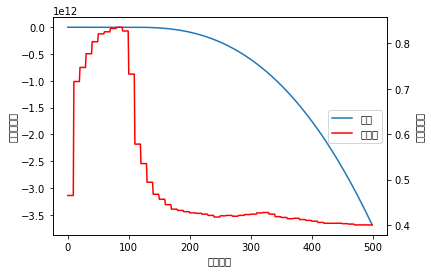

In [27]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['KaiTi']

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
lns1 = ax1.plot(np.arange(iterations), fig_loss, label = 'Loss')
lns2 = ax2.plot(np.arange(iterations), fig_train_precision, 'r', label = 'Train Accuracy')
ax1.set_xlabel('训练轮次')
ax1.set_ylabel('训练损失值')
ax2.set_ylabel('训练准确率')
# 合并图例
lns = lns1 + lns2
labels = ['损失', '准确率']
plt.legend(lns, labels, loc=7)
plt.show()